# Simulation of the three-polarizing-filter experiment, based on this fantastic __[answer on Stack Exchange](https://quantumcomputing.stackexchange.com/a/4284)__

<font size="4"><br /><br />First some boilerplate:
</font>

In [1]:
HISTO_SIZE = (9,4)  # width, height in inches
CIRCUIT_SIZE = 1.0  # scale (e.g. 0.5 is half-size)
CIRCUIT_DRAW_STYLE = "iqp"  # "iqp" or "clifford" (new is "iqp")

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit import BasicAer as Aer
from qiskit.tools.visualization import plot_histogram

from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector

import qiskit.tools.jupyter
%qiskit_version_table

def set_backend(use_simulator: bool, n_qubits: int, preferred_backend: str=''):
    if use_simulator:
        backend = Aer.get_backend('qasm_simulator')
    else:
        from qiskit import IBMQ
        provider = IBMQ.load_account()
        if preferred_backend:
            # use backend specified by caller
            backend = provider.get_backend(preferred_backend)
            print(f"Using {backend.name()}")
        else:
            # use least-busy backend that has enough qubits
            from qiskit.providers.ibmq import least_busy
            large_enough_devices = provider.backends(filters=lambda x: x.configuration().n_qubits >= n_qubits and not x.configuration().simulator)
            backend = least_busy(large_enough_devices)
            print(f"The best backend is {backend.name()}")
    return backend

# use simulator for now
backend = set_backend(use_simulator=True, n_qubits=1)

def run_circuit():
    N=10000
    result = execute(qc, backend=backend, shots=N).result()
    counts = result.get_counts(qc)
    key_to_symbol = {
        # NP
        '00': '|∅⟩',
        '01': 'ILLEGAL',
        '10': '|H⟩',
        '11': '|V⟩',
    }
    print(f"Results (N={N})")
    print("Ket NP count\tpercnt")
    for k in ['10', '11', '00', '01']:
        if k not in counts:
            continue
        n = counts[k]
        print(f"{key_to_symbol[k]} {k} n={n}\t{100*n/N:.1f}%")

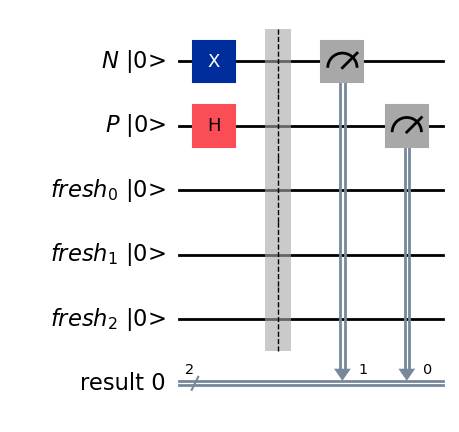

In [2]:
# 1. show input to 1st filter

N_reg = QuantumRegister(1, 'N')    # N=number, can be |0⟩ or |1⟩, |0⟩ means no photon
P_reg = QuantumRegister(1, 'P')    # P=polarization, |0⟩ is Horizontal, |1⟩ is Vertical polarization
fresh_reg = QuantumRegister(3, 'fresh') # supplies fresh qubit
c_reg = ClassicalRegister(2, 'result')  # clasical bits to hold measurement results

qc = QuantumCircuit(N_reg, P_reg, fresh_reg, c_reg)  # begin circuit

qc.x(N_reg[0])  # N - set to 1
qc.h(P_reg[0])  # P - 0=H, 1=V - rotate 90 deg (Bloch) or 45 deg (physical) to place in superposition to model sunlight (half the photons will pass through a HORIZONTAL polarizer, half will not)

qc.barrier()

# MSB is N, LSB is P, to match convention of Stack Exchange answer
qc.measure(N_reg[0], 1)
qc.measure(P_reg[0], 0)

qc.draw(output='mpl', scale=CIRCUIT_SIZE, style=CIRCUIT_DRAW_STYLE, initial_state=True)

<font size="4">
A simulated photon can be in a superposition of the following states:<br />
$
\ket{\varnothing} \equiv \ket{0}_N\ket{0}_P\,
$
(No photon),<br />
$
\ket{H} \equiv \ket{1}_N\ket{0}_P\,
$
(Photon is horizontally polarized),<br />
$
\ket{V} \equiv \ket{1}_N\ket{1}_P\,
$
(Photon is vertically polarized).<br /><br />
This is the input to the first filter. All qubits start in the ground state ( $\ket{0}$ ), which is shown here, but not shown below to reduce clutter. The N qubit (N=number, can be $\ket{0}$ or $\ket{1}$, $\ket{0}$ means no photon) is inverted by the X gate, so the inut to the first filter is $\ket{1}$. The P qubit (P is polarization, $\ket{0}$=H, $\ket{1}$=V) starts at $\ket{0}$, but gets placed into a superposition of $\ket{0}$ and $\ket{1}$ by the Hadamard (H) gate. This results in a superposition of $\ket{H}$ and $\ket{V}$.
</font>

In [3]:
run_circuit()

Results (N=10000)
Ket NP count	percnt
|H⟩ 10 n=5058	50.6%
|V⟩ 11 n=4942	49.4%


<font size="4">
Input to first filter: half are 
$
\ket{H} \equiv \ket{1}_N\ket{0}_P\,,
$
half are
$
\ket{V} \equiv \ket{1}_N\ket{1}_P\,.
$
<br />  
<br />  
<br />    
Next: run first filter
$(F_H)$
</font>

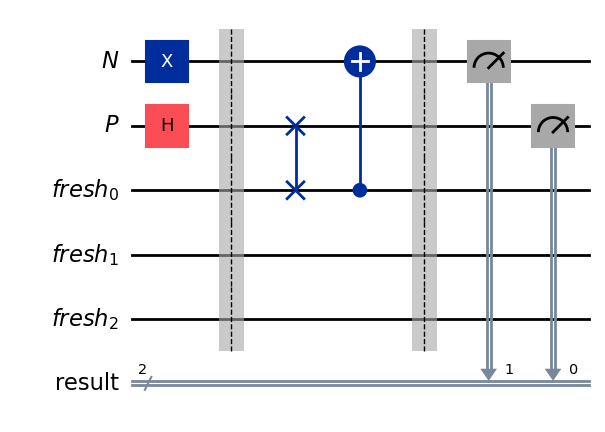

In [4]:
# 2. Only first filter

N_reg = QuantumRegister(1, 'N')    # N=number, can be |0⟩ or |1⟩, |0⟩ means no photon
P_reg = QuantumRegister(1, 'P')    # P=polarization, |0⟩ is Horizontal, |1⟩ is Vertical polarization
fresh_reg = QuantumRegister(3, 'fresh') # supplies fresh qubit
c_reg = ClassicalRegister(2, 'result')  # clasical bits to hold measurement results

qc = QuantumCircuit(N_reg, P_reg, fresh_reg, c_reg)  # begin circuit

qc.x(N_reg[0])  # N - set to 1
qc.h(P_reg[0])  # P - 0=H, 1=V - rotate 90 deg (Bloch) or 45 deg (physical) to place in superposition to model sunlight (half the photons will pass through a HORIZONTAL polarizer, half will not)

qc.barrier()

# Horizontal
qc.swap(P_reg[0],fresh_reg[0])
qc.cx(fresh_reg[0], N_reg[0])
qc.barrier()

# MSB is N, LSB is P, to match convention of Stack Exchange answer
qc.measure(N_reg[0], 1)
qc.measure(P_reg[0], 0)

# circuit is now complete
qc.draw(output='mpl', scale=CIRCUIT_SIZE, style=CIRCUIT_DRAW_STYLE, reverse_bits=False, initial_state=False)

In [5]:
run_circuit()

Results (N=10000)
Ket NP count	percnt
|H⟩ 10 n=4943	49.4%
|∅⟩ 00 n=5057	50.6%


<font size="4">
After the $F_H$ filter, half are 
$\ket{H} \equiv \ket{1}_N\ket{0}_P\,,$
and the other half are
$\ket{\varnothing} \equiv \ket{0}_N\ket{0}_P$. (nothing). The $F_H$ filter removed the $\ket{V}$ (vertical) photons.
<br /><br /><br />
Now let's follow the $F_H$ with the $F_V$ filter.
</font>

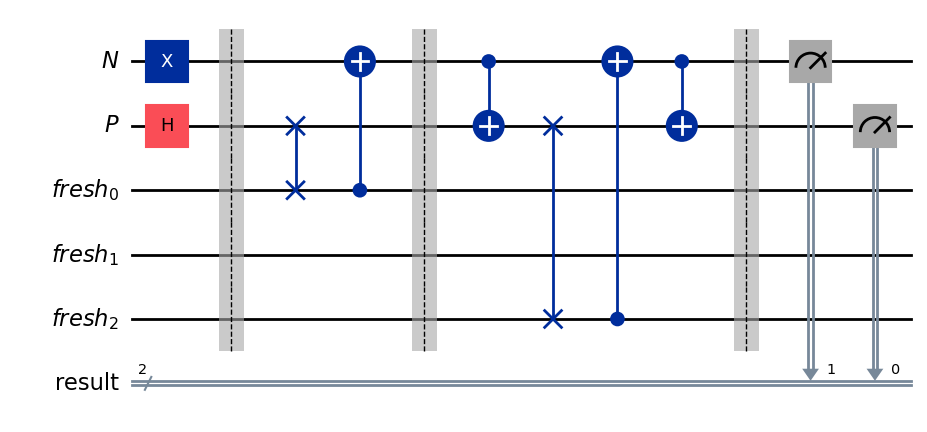

In [6]:
# 3. 1st and 3rd filter

N_reg = QuantumRegister(1, 'N')    # N=number, can be |0⟩ or |1⟩, |0⟩ means no photon
P_reg = QuantumRegister(1, 'P')    # P=polarization, |0⟩ is Horizontal, |1⟩ is Vertical polarization
fresh_reg = QuantumRegister(3, 'fresh') # supplies fresh qubit
c_reg = ClassicalRegister(2, 'result')  # clasical bits to hold measurement results

qc = QuantumCircuit(N_reg, P_reg, fresh_reg, c_reg)  # begin circuit

qc.x(N_reg[0])  # N - set to 1
qc.h(P_reg[0])  # P - 0=H, 1=V - rotate 90 deg (Bloch) or 45 deg (physical) to place in superposition to model sunlight (half the photons will pass through a HORIZONTAL polarizer, half will not)

qc.barrier()

# Horizontal
qc.swap(P_reg[0],fresh_reg[0])
qc.cx(fresh_reg[0], N_reg[0])
qc.barrier()

# Vertical
qc.cx(N_reg[0], P_reg[0])
qc.swap(P_reg[0],fresh_reg[2])
qc.cx(fresh_reg[2], N_reg[0])
qc.cx(N_reg[0], P_reg[0])
qc.barrier()

# MSB is N, LSB is P, to match convention of Stack Exchange answer
qc.measure(N_reg[0], 1)
qc.measure(P_reg[0], 0)

# circuit is now complete
qc.draw(output='mpl', scale=CIRCUIT_SIZE, style=CIRCUIT_DRAW_STYLE, reverse_bits=False, initial_state=False)

In [7]:
run_circuit()

Results (N=10000)
Ket NP count	percnt
|∅⟩ 00 n=10000	100.0%


<font size="4">
After the $F_H$ and the $F_V$ filters, no photons got through.
<br /><br /><br />
Now let's place a diagonal ($F_D$) filter between the $F_H$ and the $F_V$ filters.
</font>

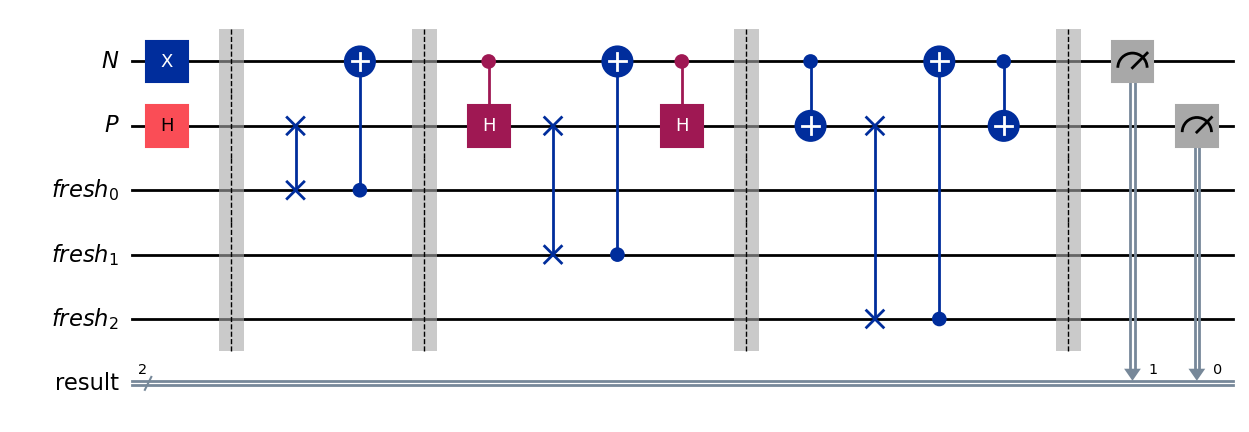

In [8]:
# 4. all 3 filters

N_reg = QuantumRegister(1, 'N')    # N=number, can be |0⟩ or |1⟩, |0⟩ means no photon
P_reg = QuantumRegister(1, 'P')    # P=polarization, |0⟩ is Horizontal, |1⟩ is Vertical polarization
fresh_reg = QuantumRegister(3, 'fresh') # supplies fresh qubit
c_reg = ClassicalRegister(2, 'result')  # clasical bits to hold measurement results

qc = QuantumCircuit(N_reg, P_reg, fresh_reg, c_reg)  # begin circuit

qc.x(N_reg[0])  # N - set to 1
qc.h(P_reg[0])  # P - 0=H, 1=V - rotate 90 deg (Bloch) or 45 deg (physical) to place in superposition to model sunlight (half the photons will pass through a HORIZONTAL polarizer, half will not)

qc.barrier()

# Horizontal
qc.swap(P_reg[0],fresh_reg[0])
qc.cx(fresh_reg[0], N_reg[0])
qc.barrier()

# Diagonal
qc.ch(N_reg[0], P_reg[0])
qc.swap(P_reg[0], fresh_reg[1])
qc.cx(fresh_reg[1], N_reg[0])
qc.ch(N_reg[0], P_reg[0])
qc.barrier()

# Vertical
qc.cx(N_reg[0], P_reg[0])
qc.swap(P_reg[0],fresh_reg[2])
qc.cx(fresh_reg[2], N_reg[0])
qc.cx(N_reg[0], P_reg[0])
qc.barrier()

# MSB is N, LSB is P, to match convention of Stack Exchange answer
qc.measure(N_reg[0], 1)
qc.measure(P_reg[0], 0)

# circuit is now complete
qc.draw(output='mpl', scale=CIRCUIT_SIZE, style=CIRCUIT_DRAW_STYLE, reverse_bits=False, initial_state=False)

In [9]:
run_circuit()

Results (N=10000)
Ket NP count	percnt
|V⟩ 11 n=1245	12.4%
|∅⟩ 00 n=8755	87.5%


<font size="4">
After inserting the $F_D$ filter between the $F_H$ and the $F_V$ filters, we see about 12.5% (1/8) of the photons get through. All are vertically-polarized.<br />
This is the suprising part - adding a filter lets more light through.
<br /><br /><br />
To see why, let's try just the first 2 filters - $F_H$ followed by $F_D$:
</font>

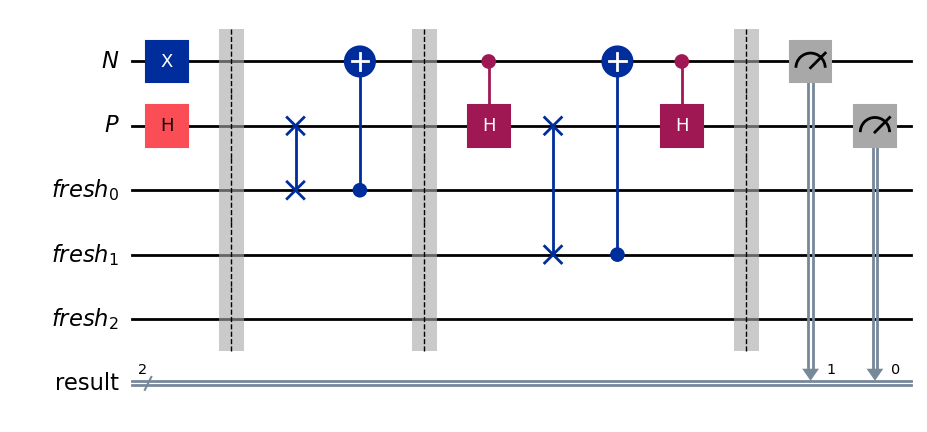

In [10]:
# 5. First 2 filters (H + D)

N_reg = QuantumRegister(1, 'N')    # N=number, can be |0⟩ or |1⟩, |0⟩ means no photon
P_reg = QuantumRegister(1, 'P')    # P=polarization, |0⟩ is Horizontal, |1⟩ is Vertical polarization
fresh_reg = QuantumRegister(3, 'fresh') # supplies fresh qubit
c_reg = ClassicalRegister(2, 'result')  # clasical bits to hold measurement results

qc = QuantumCircuit(N_reg, P_reg, fresh_reg, c_reg)  # begin circuit

qc.x(N_reg[0])  # N - set to 1
qc.h(P_reg[0])  # P - 0=H, 1=V - rotate 90 deg (Bloch) or 45 deg (physical) to place in superposition to model sunlight (half the photons will pass through a HORIZONTAL polarizer, half will not)

qc.barrier()

# Horizontal
qc.swap(P_reg[0],fresh_reg[0])
qc.cx(fresh_reg[0], N_reg[0])
qc.barrier()

# Diagonal
qc.ch(N_reg[0], P_reg[0])
qc.swap(P_reg[0], fresh_reg[1])
qc.cx(fresh_reg[1], N_reg[0])
qc.ch(N_reg[0], P_reg[0])
qc.barrier()

# MSB is N, LSB is P, to match convention of Stack Exchange answer
qc.measure(N_reg[0], 1)
qc.measure(P_reg[0], 0)

# circuit is now complete
qc.draw(output='mpl', scale=CIRCUIT_SIZE, style=CIRCUIT_DRAW_STYLE, reverse_bits=False, initial_state=False)

In [11]:
run_circuit()

Results (N=10000)
Ket NP count	percnt
|H⟩ 10 n=1269	12.7%
|V⟩ 11 n=1272	12.7%
|∅⟩ 00 n=7459	74.6%


<font size="4">
After the $F_H$ and the $F_D$ filters, 1/4 photons got through. Half are horizontally polarized, half are vertical. These (horizontal+vertical) are diagonally-polarized, and why half of them get through the vertical polarizer.
</font>